In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


C:\Users\DHARSAN k\AppData\Roaming\Python\Python311\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class RFMiDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = self.df['ID']
        self.labels = self.df.iloc[:, 1:].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img_name = str(self.image_names[idx])
            img_path = os.path.join(self.image_dir, img_name + '.png')
            image = np.array(Image.open(img_path).convert('RGB'))
    
            if self.transform:
                image = self.transform(image=image)['image']
    
            label = torch.tensor(self.labels[idx], dtype=torch.float32)  # <-- Force label to float
            return image, label
        except Exception as e:
            print(f"error loading image {img_name}; {e}")
            return torch.zeros(3, 224, 224), torch.zeros(45, dtype=torch.float32)


In [3]:
# Define image transforms
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [4]:
# Paths
 # <-- Update this to your actual root
train_img_dir ="Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/a. Training Set"
val_img_dir = "Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/b. Validation Set"
test_img_dir =  "Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/c. Testing Set"

train_labels = pd.read_csv( "Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/a. RFMiD_Training_Labels.csv")
val_labels = pd.read_csv( "Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/b. RFMiD_Validation_Labels.csv")
test_labels = pd.read_csv( "Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/c. RFMiD_Testing_Labels.csv")

# Datasets
train_dataset = RFMiDDataset(train_labels, train_img_dir, transform=train_transform)
val_dataset = RFMiDDataset(val_labels, val_img_dir, transform=val_test_transform)
test_dataset = RFMiDDataset(test_labels, test_img_dir, transform=val_test_transform)


In [5]:
# Dataloaders
BATCH_SIZE = 16  # You can increase if your GPU allows

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [6]:
import timm
import torch.nn as nn

# Model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=29)
model = model.cuda()


In [7]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [8]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(dataloader.dataset)


C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [9]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            print(images.shape)
            images, labels = images.cuda(), labels.cuda()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

    val_loss = running_loss / len(dataloader.dataset)
    y_true = np.vstack(all_targets)
    y_pred = np.vstack(all_outputs)
    return val_loss, y_true, y_pred


In [10]:
from sklearn.metrics import roc_auc_score

def compute_auroc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred, average='macro')  # multi-label AUROC
    except ValueError:
        return 0.0


In [11]:
df = pd.read_csv('Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/a. RFMiD_Training_Labels.csv')

label_cols = df.columns[1:]  # or better, explicitly exclude non-label columns
print(len(label_cols))       # This should print 45
print(label_cols.tolist())   # So you can double-check column names


29
['Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST', 'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER']


In [12]:
import os
import copy

EPOCHS = 20
best_auroc = 0
train_losses = []
val_losses = []
val_aurocs = []

best_model_weights = copy.deepcopy(model.state_dict())

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, y_true, y_pred = validate(model, val_loader, criterion)
    val_auroc = compute_auroc(y_true, y_pred)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUROC: {val_auroc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)

    # Save best model
    if val_auroc > best_auroc:
        best_auroc = val_auroc
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(best_model_weights, 'best_model_by_auroc.pth')
        print("✅ Saved new best model.")



Epoch 1/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:49,  1.28s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:49,  1.31s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:48,  1.31s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:05<00:49,  1.37s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:06<00:48,  1.39s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:08<00:48,  1.43s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:09<00:47,  1.44s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:11<00:44,  1.39s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:12<00:42,  1.37s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:13<00:41,  1.38s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:15<00:40,  1.40s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:16<00:39,  1.41s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:18<00:38,  1.44s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:19<00:38,  1.48s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:21<00:36,  1.46s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:22<00:34,  1.44s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:24<00:33,  1.44s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:26<00:30,  1.43s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:28<00:29,  1.46s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:29<00:27,  1.46s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:31<00:26,  1.45s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:32<00:24,  1.44s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:34<00:22,  1.43s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:35<00:21,  1.43s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:36<00:19,  1.42s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:38<00:18,  1.40s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:39<00:17,  1.45s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:41<00:15,  1.41s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:42<00:14,  1.46s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:44<00:13,  1.51s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:50<00:22,  2.81s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:01<00:25,  4.25s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:06<00:12,  3.17s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:07<00:08,  2.74s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:11<00:05,  2.95s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:16<00:03,  3.70s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.06s/it]


Train Loss: 0.2556, Val Loss: 0.1206, Val AUROC: 0.6951
✅ Saved new best model.

Epoch 2/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:42,  1.08s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.05s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.09s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:40,  1.11s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:41,  1.21s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:38,  1.16s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:35,  1.11s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:33,  1.11s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:31,  1.10s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:29,  1.14s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:28,  1.15s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:25,  1.10s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:22,  1.05s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:21<00:22,  1.06s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:20,  1.07s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:24<00:19,  1.08s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:25<00:18,  1.07s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:26<00:17,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:28<00:15,  1.09s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:29<00:14,  1.12s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:13,  1.09s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:32<00:11,  1.08s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:33<00:10,  1.07s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:34<00:10,  1.15s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:39<00:19,  2.46s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:45<00:23,  3.38s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:50<00:23,  3.98s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:54<00:11,  2.95s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:56<00:07,  2.51s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:59<00:05,  2.75s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  4.08s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  1.76s/it]


Train Loss: 0.1005, Val Loss: 0.1054, Val AUROC: 0.7763
✅ Saved new best model.

Epoch 3/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:39,  1.02s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:38,  1.03s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:39,  1.08s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:40,  1.12s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:39,  1.14s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:39,  1.16s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:39,  1.20s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:37,  1.20s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:36,  1.21s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:34,  1.20s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:33,  1.20s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:32,  1.19s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:30,  1.18s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:30,  1.22s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:27,  1.16s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:26,  1.16s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:25,  1.17s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:22<00:24,  1.17s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:23,  1.19s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:23,  1.22s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:21,  1.22s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:27<00:20,  1.20s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:29<00:18,  1.23s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:30<00:17,  1.22s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:15,  1.21s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:14,  1.20s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:34<00:13,  1.19s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:35<00:11,  1.19s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:37<00:11,  1.30s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:42<00:20,  2.61s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:24,  3.51s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:53<00:24,  4.10s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:58<00:12,  3.07s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:59<00:07,  2.58s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:02<00:05,  2.78s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:08<00:03,  3.56s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.85s/it]


Train Loss: 0.0820, Val Loss: 0.1007, Val AUROC: 0.8063
✅ Saved new best model.

Epoch 4/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:44,  1.14s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:41,  1.10s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:41,  1.12s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:41,  1.15s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:39,  1.12s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:38,  1.15s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:38,  1.17s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:37,  1.18s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:36,  1.17s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:33,  1.13s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:31,  1.10s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.09s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:14<00:30,  1.12s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:28,  1.10s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:27,  1.10s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:26,  1.09s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:25,  1.11s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:23,  1.07s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:21<00:22,  1.05s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:22<00:21,  1.07s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:20,  1.06s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:24<00:19,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:26<00:17,  1.09s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:27<00:16,  1.09s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:28<00:15,  1.07s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:29<00:13,  1.07s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:12,  1.02s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:31<00:10,  1.02it/s]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:32<00:10,  1.02s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:34<00:10,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:39<00:20,  2.52s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:45<00:23,  3.39s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:53<00:17,  3.51s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:54<00:11,  2.93s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:56<00:07,  2.53s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:59<00:05,  2.77s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  4.18s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  1.76s/it]


Train Loss: 0.0688, Val Loss: 0.0987, Val AUROC: 0.8219
✅ Saved new best model.

Epoch 5/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:43,  1.10s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:41,  1.10s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:41,  1.15s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:40,  1.16s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:39,  1.16s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:38,  1.16s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:36,  1.13s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:35,  1.13s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:33,  1.11s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:33,  1.14s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:32,  1.17s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:32,  1.19s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:30,  1.18s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:28,  1.15s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:27,  1.15s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:26,  1.15s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:23,  1.09s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:21<00:22,  1.07s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:22<00:20,  1.05s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:20,  1.06s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:25<00:19,  1.12s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:27<00:17,  1.09s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:29<00:15,  1.13s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:31<00:13,  1.11s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:32<00:12,  1.11s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:33<00:11,  1.11s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:40<00:19,  2.50s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:46<00:23,  3.35s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:53<00:17,  3.52s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:55<00:11,  2.90s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:57<00:07,  2.53s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:05<00:03,  3.51s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:11<00:00,  1.78s/it]


Train Loss: 0.0565, Val Loss: 0.0984, Val AUROC: 0.8274
✅ Saved new best model.

Epoch 6/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:41,  1.05s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.05s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.10s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.07s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:38,  1.10s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:39,  1.18s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:40,  1.23s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:39,  1.23s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:37,  1.21s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:36,  1.22s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:36,  1.25s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:34,  1.21s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:33,  1.23s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:31,  1.21s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:30,  1.21s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:28,  1.19s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:27,  1.19s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:25,  1.17s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:22<00:24,  1.15s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:23,  1.20s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:22,  1.18s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:25<00:20,  1.16s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:27<00:19,  1.16s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:28<00:18,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:30<00:16,  1.18s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:14,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:35<00:11,  1.20s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:36<00:11,  1.26s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:42<00:20,  2.52s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:52<00:23,  3.89s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:56<00:11,  2.85s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:58<00:07,  2.43s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:01<00:05,  2.67s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:06<00:03,  3.47s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:12<00:00,  1.80s/it]


Train Loss: 0.0456, Val Loss: 0.0999, Val AUROC: 0.8280
✅ Saved new best model.

Epoch 7/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:39,  1.01s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.04s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:39,  1.06s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.07s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:40,  1.17s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:40,  1.18s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:39,  1.20s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:38,  1.21s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:35,  1.20s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:35,  1.21s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:34,  1.22s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:32,  1.21s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:31,  1.21s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:30,  1.21s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:28,  1.18s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:26,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:26,  1.19s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:24,  1.23s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:23,  1.22s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:21,  1.20s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:27<00:20,  1.19s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:28<00:18,  1.18s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:29<00:17,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:15,  1.19s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:14,  1.23s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:34<00:12,  1.18s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:35<00:11,  1.20s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:37<00:11,  1.31s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:42<00:20,  2.58s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:24,  3.45s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:55<00:17,  3.53s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:57<00:11,  2.89s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:59<00:07,  2.53s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:02<00:05,  2.78s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  4.11s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.83s/it]


Train Loss: 0.0370, Val Loss: 0.1001, Val AUROC: 0.8466
✅ Saved new best model.

Epoch 8/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:41,  1.07s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.05s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:38,  1.05s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:39,  1.09s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:38,  1.14s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:07<00:38,  1.15s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:35,  1.13s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:33,  1.12s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:33,  1.14s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.11s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:14<00:29,  1.09s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:28,  1.08s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:26,  1.07s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:25,  1.07s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:18<00:25,  1.09s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:19<00:23,  1.08s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:20<00:22,  1.08s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:22<00:22,  1.12s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:20,  1.10s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:24<00:19,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:26<00:16,  1.05s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:27<00:15,  1.05s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:28<00:14,  1.06s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:29<00:14,  1.10s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:13,  1.11s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:31<00:12,  1.11s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:32<00:11,  1.10s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:34<00:10,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:39<00:20,  2.53s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:45<00:24,  3.45s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:53<00:17,  3.51s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:54<00:11,  2.92s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:59<00:05,  2.70s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:04<00:03,  3.49s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  4.12s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  1.76s/it]


Train Loss: 0.0294, Val Loss: 0.1065, Val AUROC: 0.8341

Epoch 9/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:40,  1.03s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.03s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:38,  1.04s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:39,  1.09s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:41,  1.18s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:41,  1.21s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:40,  1.23s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:40,  1.25s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:38,  1.24s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:36,  1.23s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:35,  1.22s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:33,  1.19s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:32,  1.22s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:31,  1.21s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:30,  1.23s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:19<00:29,  1.23s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:29,  1.28s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:26,  1.22s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:22<00:25,  1.21s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:24<00:24,  1.20s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:21,  1.22s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:27<00:20,  1.19s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:28<00:18,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:31<00:16,  1.19s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:15,  1.17s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:14,  1.21s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:36<00:12,  1.21s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:37<00:11,  1.28s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:43<00:20,  2.54s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:23,  3.38s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:56<00:17,  3.49s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:57<00:11,  2.90s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:59<00:07,  2.49s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:02<00:05,  2.70s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:07<00:03,  3.52s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.83s/it]


Train Loss: 0.0220, Val Loss: 0.1055, Val AUROC: 0.8389

Epoch 10/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:50,  1.29s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:49,  1.30s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:05<00:46,  1.28s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:06<00:45,  1.31s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:07<00:44,  1.29s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:09<00:44,  1.35s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:10<00:42,  1.32s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:11<00:41,  1.33s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:13<00:40,  1.35s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:14<00:38,  1.33s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:15<00:37,  1.33s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:17<00:37,  1.40s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:18<00:34,  1.34s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:19<00:32,  1.29s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:21<00:30,  1.28s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:23<00:27,  1.23s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:24<00:25,  1.21s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:26<00:25,  1.26s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:27<00:24,  1.26s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:28<00:23,  1.28s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:29<00:20,  1.22s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:30<00:18,  1.18s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:31<00:17,  1.18s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:33<00:16,  1.20s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:34<00:16,  1.25s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:35<00:14,  1.24s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:36<00:13,  1.21s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:38<00:12,  1.22s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:39<00:11,  1.32s/it]

torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:45<00:21,  2.66s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:56<00:24,  4.02s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:58<00:17,  3.53s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:00<00:11,  2.90s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:01<00:07,  2.52s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:05<00:05,  2.76s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:16<00:00,  1.90s/it]


torch.Size([16, 3, 224, 224])
Train Loss: 0.0190, Val Loss: 0.1061, Val AUROC: 0.8407

Epoch 11/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:42,  1.08s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:40,  1.08s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:39,  1.07s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:39,  1.11s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:39,  1.14s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:40,  1.18s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:39,  1.21s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:39,  1.23s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:37,  1.20s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:36,  1.20s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:35,  1.22s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:34,  1.23s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:32,  1.24s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:18<00:32,  1.30s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:19<00:30,  1.27s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:28,  1.25s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:27,  1.25s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:23<00:26,  1.28s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:24<00:25,  1.25s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:25<00:24,  1.26s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:23,  1.28s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:28<00:21,  1.26s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:29<00:19,  1.22s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:30<00:18,  1.22s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:31<00:16,  1.21s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:15,  1.21s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:34<00:14,  1.21s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:35<00:12,  1.15s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:36<00:11,  1.14s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:37<00:11,  1.25s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:24,  3.46s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:56<00:17,  3.57s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:00<00:07,  2.61s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:03<00:05,  2.87s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:09<00:03,  3.68s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:14<00:00,  1.87s/it]


Train Loss: 0.0166, Val Loss: 0.1075, Val AUROC: 0.8390

Epoch 12/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:44,  1.14s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:43,  1.14s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:43,  1.18s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:41,  1.14s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:40,  1.15s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:07<00:40,  1.19s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:41,  1.24s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:38,  1.21s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:36,  1.18s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:35,  1.19s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:34,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:32,  1.22s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:31,  1.20s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:29,  1.18s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:19<00:28,  1.18s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:26,  1.22s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:22<00:24,  1.17s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:23,  1.16s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:22,  1.16s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:20,  1.15s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:27<00:20,  1.23s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:30<00:19,  1.27s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:31<00:18,  1.31s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:17,  1.35s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:34<00:16,  1.34s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:35<00:14,  1.28s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:36<00:12,  1.27s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:43<00:20,  2.57s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:23,  3.36s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:53<00:23,  3.91s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:56<00:17,  3.43s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:57<00:11,  2.87s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:59<00:07,  2.50s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:02<00:05,  2.72s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:08<00:03,  3.51s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.85s/it]


Train Loss: 0.0136, Val Loss: 0.1101, Val AUROC: 0.8377

Epoch 13/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:42,  1.10s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:40,  1.07s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:38,  1.05s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.07s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:38,  1.13s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:07<00:37,  1.14s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:08<00:36,  1.15s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:34,  1.11s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:32,  1.10s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:32,  1.13s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:31,  1.14s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:14<00:31,  1.18s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:28,  1.16s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:27,  1.16s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:26,  1.14s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:24,  1.11s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:21<00:23,  1.12s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:22<00:23,  1.15s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:21,  1.14s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:24<00:19,  1.10s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:25<00:18,  1.10s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:28<00:16,  1.12s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:29<00:15,  1.14s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:30<00:14,  1.10s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:31<00:13,  1.11s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:32<00:12,  1.14s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:33<00:11,  1.12s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:41<00:20,  2.62s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:46<00:23,  3.39s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:51<00:23,  3.87s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:55<00:11,  2.87s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:56<00:07,  2.45s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:59<00:05,  2.65s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:05<00:03,  3.41s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  1.76s/it]


Train Loss: 0.0137, Val Loss: 0.1093, Val AUROC: 0.8362

Epoch 14/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:46,  1.19s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:42,  1.13s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.10s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.06s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:37,  1.08s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:37,  1.12s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:07<00:36,  1.10s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:08<00:34,  1.09s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:09<00:33,  1.08s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:10<00:32,  1.10s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:31,  1.09s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.10s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:29,  1.14s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:27,  1.11s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:26,  1.12s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:18<00:24,  1.07s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:19<00:23,  1.05s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:20<00:21,  1.04s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:21<00:20,  1.04s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:23<00:18,  1.03s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:24<00:17,  1.03s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:25<00:16,  1.00s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:26<00:15,  1.01s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:27<00:14,  1.03s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:28<00:13,  1.04s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:12,  1.04s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:31<00:11,  1.04s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:32<00:10,  1.06s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:33<00:10,  1.16s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:38<00:19,  2.39s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:48<00:22,  3.74s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:51<00:16,  3.34s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:52<00:11,  2.77s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:57<00:05,  2.60s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:07<00:00,  1.70s/it]


torch.Size([16, 3, 224, 224])
Train Loss: 0.0131, Val Loss: 0.1110, Val AUROC: 0.8382

Epoch 15/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:41,  1.06s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:40,  1.07s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.11s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:39,  1.10s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:41,  1.20s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:40,  1.18s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:39,  1.19s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:38,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:37,  1.25s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:35,  1.24s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:34,  1.23s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:33,  1.24s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:32,  1.27s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:18<00:30,  1.24s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:19<00:29,  1.22s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:28,  1.22s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:21<00:26,  1.19s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:22<00:24,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:25<00:22,  1.20s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:26<00:21,  1.18s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:28<00:18,  1.16s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:29<00:17,  1.14s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:31<00:16,  1.17s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:15,  1.16s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:14,  1.21s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:34<00:13,  1.19s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:35<00:12,  1.20s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:37<00:11,  1.26s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:42<00:20,  2.51s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:48<00:23,  3.35s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:53<00:23,  3.89s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:57<00:11,  2.85s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:58<00:07,  2.45s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:01<00:05,  2.71s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:07<00:03,  3.50s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:12<00:00,  1.82s/it]


Train Loss: 0.0119, Val Loss: 0.1107, Val AUROC: 0.8411

Epoch 16/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:42,  1.09s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:39,  1.05s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:39,  1.06s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.07s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:38,  1.14s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:07<00:37,  1.13s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:08<00:36,  1.15s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:09<00:33,  1.09s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:10<00:32,  1.08s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:31,  1.10s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.09s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:14<00:30,  1.12s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:28,  1.08s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:27,  1.09s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:26,  1.09s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:18<00:24,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:20<00:23,  1.13s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:22<00:22,  1.13s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:23<00:21,  1.11s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:25<00:18,  1.08s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:26<00:17,  1.06s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:27<00:15,  1.05s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:28<00:14,  1.06s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:29<00:13,  1.05s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:12,  1.04s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:31<00:11,  1.05s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:32<00:10,  1.04s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:33<00:10,  1.15s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:39<00:19,  2.40s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:44<00:22,  3.24s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:49<00:22,  3.80s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:52<00:16,  3.39s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:55<00:07,  2.42s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:58<00:05,  2.65s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:03<00:03,  3.43s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:08<00:00,  1.72s/it]


Train Loss: 0.0105, Val Loss: 0.1128, Val AUROC: 0.8407

Epoch 17/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:44,  1.15s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:42,  1.12s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.09s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:38,  1.08s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:39,  1.11s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:06<00:36,  1.07s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:07<00:35,  1.07s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:08<00:34,  1.08s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:09<00:33,  1.08s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:10<00:32,  1.07s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:11<00:31,  1.08s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:30,  1.09s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:14<00:29,  1.10s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:15<00:28,  1.09s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:27,  1.08s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:25,  1.07s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:18<00:24,  1.06s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:20<00:22,  1.06s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:21<00:21,  1.09s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:22<00:20,  1.08s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:23<00:19,  1.08s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:25<00:16,  1.05s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:26<00:15,  1.04s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:27<00:14,  1.04s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:30<00:12,  1.05s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:31<00:11,  1.06s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:32<00:10,  1.09s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:33<00:10,  1.12s/it]

torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:38<00:19,  2.41s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:44<00:22,  3.28s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:49<00:23,  3.87s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:53<00:11,  2.92s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:55<00:07,  2.51s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:58<00:05,  2.78s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:10<00:00,  1.76s/it]


torch.Size([16, 3, 224, 224])
Train Loss: 0.0108, Val Loss: 0.1124, Val AUROC: 0.8412

Epoch 18/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:43,  1.12s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:44,  1.17s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:42,  1.15s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:41,  1.15s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:05<00:40,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:37,  1.15s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:36,  1.14s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:36,  1.17s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:11<00:35,  1.17s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:35,  1.21s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:32,  1.16s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:31,  1.18s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:29,  1.17s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:28,  1.17s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:26,  1.15s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:25,  1.14s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:23,  1.18s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:22,  1.17s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:25<00:21,  1.17s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:26<00:19,  1.13s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:27<00:17,  1.10s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:28<00:16,  1.08s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:29<00:15,  1.07s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:30<00:13,  1.07s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:33<00:12,  1.09s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:34<00:11,  1.11s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:35<00:11,  1.25s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:41<00:21,  2.66s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:47<00:24,  3.54s/it]

torch.Size([16, 3, 224, 224])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:52<00:24,  4.02s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:55<00:17,  3.59s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:58<00:07,  2.55s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:01<00:05,  2.72s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:06<00:03,  3.47s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:12<00:00,  1.80s/it]


Train Loss: 0.0101, Val Loss: 0.1128, Val AUROC: 0.8423

Epoch 19/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:43,  1.12s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:44,  1.17s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:45,  1.24s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:43,  1.21s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:06<00:42,  1.21s/it]

torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:07<00:45,  1.35s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:10<00:43,  1.36s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:11<00:40,  1.31s/it]

torch.Size([16, 3, 224, 224])


 25%|████████████████████▌                                                             | 10/40 [00:12<00:38,  1.27s/it]

torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:35,  1.22s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:15<00:33,  1.20s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:17<00:31,  1.23s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:18<00:31,  1.24s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:21<00:30,  1.32s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:22<00:28,  1.30s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:24<00:27,  1.31s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:25<00:26,  1.33s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:26<00:24,  1.29s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:28<00:22,  1.28s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:30<00:20,  1.26s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:31<00:18,  1.23s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:32<00:17,  1.22s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:34<00:16,  1.25s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:35<00:14,  1.23s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:36<00:13,  1.25s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:37<00:12,  1.21s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:45<00:20,  2.61s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:50<00:24,  3.45s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:58<00:17,  3.60s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:59<00:11,  2.97s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:01<00:07,  2.57s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:04<00:05,  2.78s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:10<00:03,  3.56s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:15<00:00,  1.90s/it]


Train Loss: 0.0098, Val Loss: 0.1127, Val AUROC: 0.8398

Epoch 20/20


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\2947082219.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  2%|██                                                                                 | 1/40 [00:01<00:42,  1.10s/it]

torch.Size([16, 3, 224, 224])


  5%|████▏                                                                              | 2/40 [00:02<00:40,  1.07s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:03<00:40,  1.10s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:04<00:42,  1.17s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 15%|████████████▍                                                                      | 6/40 [00:07<00:43,  1.29s/it]

torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:08<00:40,  1.23s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:09<00:38,  1.21s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:10<00:36,  1.19s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:36,  1.25s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:34,  1.27s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:17<00:32,  1.26s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:18<00:30,  1.23s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:20<00:28,  1.23s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:22<00:26,  1.21s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:23<00:25,  1.23s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:25<00:23,  1.24s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:27<00:22,  1.25s/it]

torch.Size([16, 3, 224, 224])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:28<00:22,  1.30s/it]

torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:29<00:20,  1.31s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:31<00:19,  1.30s/it]

torch.Size([16, 3, 224, 224])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:32<00:18,  1.31s/it]

torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:33<00:16,  1.25s/it]

torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:34<00:14,  1.22s/it]

torch.Size([16, 3, 224, 224])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:36<00:13,  1.25s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:37<00:12,  1.25s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:38<00:12,  1.34s/it]

torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:44<00:21,  2.64s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:50<00:24,  3.52s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:58<00:18,  3.66s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:59<00:12,  3.04s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:01<00:07,  2.64s/it]

torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:04<00:05,  2.86s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:10<00:03,  3.68s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:16<00:00,  1.90s/it]

Train Loss: 0.0106, Val Loss: 0.1166, Val AUROC: 0.8357


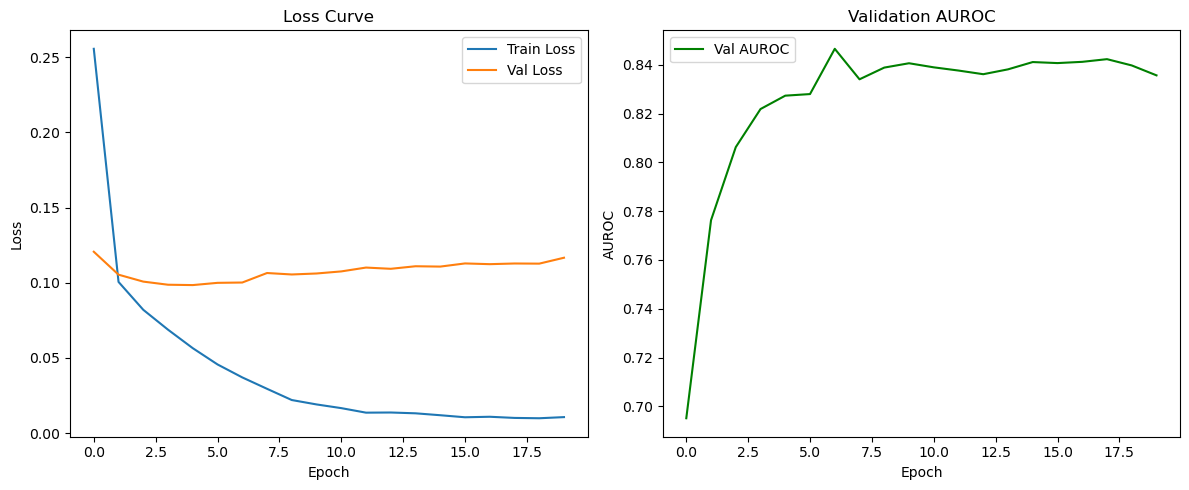

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aurocs, label='Val AUROC', color='green')
plt.title('Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred, class_names):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
plot_roc(y_true, y_pred, class_names)  # after validation

NameError: name 'class_names' is not defined

In [16]:
# Load the best model
model.load_state_dict(torch.load('best_model_by_auroc.pth'))

# Evaluate on test set
test_loss, y_true_test, y_pred_test = validate(model, test_loader, criterion)
test_auroc = compute_auroc(y_true_test, y_pred_test)

print(f"\n🔍 Test Loss: {test_loss:.4f}")
print(f"🔍 Test AUROC: {test_auroc:.4f}")


C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\1680550343.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_by_auroc.pt

torch.Size([16, 3, 224, 224])


C:\Users\DHARSAN k\AppData\Local\Temp\ipykernel_17836\1050150480.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  5%|████▏                                                                              | 2/40 [00:02<00:50,  1.34s/it]

torch.Size([16, 3, 224, 224])


  8%|██████▏                                                                            | 3/40 [00:04<00:52,  1.42s/it]

torch.Size([16, 3, 224, 224])


 10%|████████▎                                                                          | 4/40 [00:05<00:51,  1.43s/it]

torch.Size([16, 3, 224, 224])


 12%|██████████▍                                                                        | 5/40 [00:07<00:50,  1.43s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 18%|██████████████▌                                                                    | 7/40 [00:10<00:47,  1.45s/it]

torch.Size([16, 3, 224, 224])


 20%|████████████████▌                                                                  | 8/40 [00:11<00:45,  1.43s/it]

torch.Size([16, 3, 224, 224])


 22%|██████████████████▋                                                                | 9/40 [00:12<00:44,  1.44s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 28%|██████████████████████▌                                                           | 11/40 [00:15<00:41,  1.43s/it]

torch.Size([16, 3, 224, 224])


 30%|████████████████████████▌                                                         | 12/40 [00:17<00:40,  1.45s/it]

torch.Size([16, 3, 224, 224])


 32%|██████████████████████████▋                                                       | 13/40 [00:18<00:38,  1.43s/it]

torch.Size([16, 3, 224, 224])


 35%|████████████████████████████▋                                                     | 14/40 [00:20<00:37,  1.44s/it]

torch.Size([16, 3, 224, 224])


 38%|██████████████████████████████▊                                                   | 15/40 [00:21<00:36,  1.47s/it]

torch.Size([16, 3, 224, 224])


 40%|████████████████████████████████▊                                                 | 16/40 [00:22<00:34,  1.43s/it]

torch.Size([16, 3, 224, 224])


 42%|██████████████████████████████████▊                                               | 17/40 [00:24<00:33,  1.44s/it]

torch.Size([16, 3, 224, 224])


 45%|████████████████████████████████████▉                                             | 18/40 [00:25<00:31,  1.41s/it]

torch.Size([16, 3, 224, 224])


 48%|██████████████████████████████████████▉                                           | 19/40 [00:27<00:29,  1.41s/it]

torch.Size([16, 3, 224, 224])


 50%|█████████████████████████████████████████                                         | 20/40 [00:28<00:28,  1.42s/it]

torch.Size([16, 3, 224, 224])


 52%|███████████████████████████████████████████                                       | 21/40 [00:30<00:26,  1.41s/it]

torch.Size([16, 3, 224, 224])


 55%|█████████████████████████████████████████████                                     | 22/40 [00:31<00:24,  1.37s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:34<00:22,  1.39s/it]

torch.Size([16, 3, 224, 224])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:35<00:21,  1.44s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:38<00:18,  1.42s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:42<00:26,  2.20s/it]

torch.Size([16, 3, 224, 224])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:54<00:40,  4.07s/it]

torch.Size([16, 3, 224, 224])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:00<00:41,  4.62s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:06<00:40,  5.02s/it]

torch.Size([16, 3, 224, 224])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:12<00:37,  5.31s/it]

torch.Size([16, 3, 224, 224])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:18<00:20,  4.03s/it]

torch.Size([16, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:19<00:13,  3.34s/it]

torch.Size([16, 3, 224, 224])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:21<00:08,  2.88s/it]

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:26<00:07,  3.58s/it]

torch.Size([16, 3, 224, 224])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:29<00:03,  3.41s/it]

torch.Size([16, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:34<00:00,  2.36s/it]


🔍 Test Loss: 0.0945
🔍 Test AUROC: 0.8374


In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='runs/RFMiD_EfficientNetB0')

# Add this into your training loop after each epoch:
writer.add_scalar('Loss/train', train_loss, epoch)
writer.add_scalar('Loss/val', val_loss, epoch)
writer.add_scalar('AUROC/val', val_auroc, epoch)


In [22]:
!pip install -q grad-cam

In [25]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def generate_grad_cam(model, image_tensor, class_idx=None):
    target_layers = [model.conv_head]
    cam = GradCAM(model=model, target_layers=target_layers)

    input_tensor = image_tensor.unsqueeze(0).cuda()
    grayscale_cam = cam(input_tensor=input_tensor, targets=None if class_idx is None else [ClassifierOutputTarget(class_idx)])
    grayscale_cam = grayscale_cam[0, :]

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # normalize for display
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    return Image.fromarray(cam_image)


In [26]:
sample_img, _ = test_dataset[0]
generate_grad_cam(model, sample_img).show()


In [27]:
%load_ext tensorboard
%tensorboard --logdir=runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "D:\anaconda\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
  File "D:\anaconda\Lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "D:\anaconda\Lib\site-packages\tensorboard\default.py", line 30, in <module>
    import pkg_resources
  File "D:\anaconda\Lib\site-packages\pkg_resources\__init__.py", line 90, in <module>
    from jaraco.text import drop_comment, join_continuation, yield_lines
  File "D:\anaconda\Lib\site-packages\setuptools\_vendor\jaraco\text\__init__.py", line 12, in <module>
    from jaraco.context import ExceptionTrap
  File "D:\anaconda\Lib\site-packages\setuptools\_vendor\jaraco\context.py", line 17, in <module>
    from backports import tarfile
ImportError: cannot import name 'tarfile' 

In [28]:
!pip uninstall backports

In [29]:
!pip install --upgrade setuptools
!pip install --upgrade wheel


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 4.2 MB/s eta 0:00:01
   ------------------------- -------------- 0.8/1.3 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
!pip install --upgrade tensorboard

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.5 MB 2.8 MB/s eta 0:00:02
   --------- ------------------------------ 1.3/5.5 MB 2.6 MB/s eta 0:00:02
   ------------- -------------------------- 1.8/5.5 MB 2.6 MB/s eta 0:00:02
   ----------------- ---------------------- 2.4/5.5 MB 2.8 MB/s eta 0:00:02
   ---------------------- ----------------- 3.1/5.5 MB 2.9 MB/s eta 0:00:01
   -------------------------- ------------- 3.7/5.5 MB 3.0 MB/s eta 0:00:01
   ---------------------------------- ----- 4.7/5.5 MB 3.2 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.


In [31]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "D:\anaconda\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
  File "D:\anaconda\Lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "D:\anaconda\Lib\site-packages\tensorboard\default.py", line 30, in <module>
    import pkg_resources
  File "D:\anaconda\Lib\site-packages\pkg_resources\__init__.py", line 90, in <module>
    from jaraco.text import drop_comment, join_continuation, yield_lines
  File "D:\anaconda\Lib\site-packages\setuptools\_vendor\jaraco\text\__init__.py", line 12, in <module>
    from jaraco.context import ExceptionTrap
  File "D:\anaconda\Lib\site-packages\setuptools\_vendor\jaraco\context.py", line 17, in <module>
    from backports import tarfile
ImportError: cannot import name 'tarfile' 

In [32]:
!pip uninstall -y backports
!pip uninstall -y jaraco.context
!pip uninstall -y jaraco.text


In [33]:
!pip install backports.tarfile
!pip install jaraco.text
!pip install --upgrade setuptools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
%reload_ext tensorboard
%tensorboard --logdir=runs